In [ ]:
import os
import torch
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import numpy as np

def load_model(model_dir, checkpoint_name, model_class):
    """
    Load the trained model and its config for inference.

    Args:
        model_dir (str): Base directory where models are saved (e.g., "trained_models/unet3d/Task08_HepaticVessel").
        checkpoint_name (str): The exact timestamped folder (e.g., "2025-03-07_01-52-17").
        model_class: The model architecture class (e.g., UNet3D).

    Returns:
        Tuple (model, cfg) - The loaded PyTorch model and its corresponding config.
    """
    checkpoint_path = os.path.join(model_dir, checkpoint_name)
    model_path = os.path.join(checkpoint_path, "model.pth")
    config_path = os.path.join(checkpoint_path, "config.yaml")

    assert os.path.exists(model_path), f"Model file not found: {model_path}"
    assert os.path.exists(config_path), f"Config file not found: {config_path}"

    print(f"Loading model from: {model_path}")
    print(f"Loading config from: {config_path}")

    # Load the saved config
    cfg = OmegaConf.load(config_path)

    # Initialize the model using the stored config
    model = model_class(
        in_channels=1,
        num_classes=cfg.training.num_classes,
        n_filters=cfg.training.n_filters,
        dropout=cfg.training.dropout,
        batch_norm=True,
    )

    # Load the saved weights
    model.load_state_dict(torch.load(model_path, map_location="cpu"))
    model.eval()  # Set to evaluation mode

    return model, cfg

def visualize_predictions(model, dataset, device, slice_idx=24, num_samples=3):
    """
    Visualize predictions for random samples from the dataset
    - model: trained model
    - dataset: HepaticVesselDataset instance
    - slice_idx: which depth slice to visualize
    - num_samples: number of samples to display
    """
    num_samples = min(num_samples, len(dataset))

    indices = np.random.choice(len(dataset), num_samples)
    
    fig, axs = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        with torch.no_grad():
            pred = model(image.unsqueeze(0).to(device)) 
            pred = torch.argmax(pred.squeeze(), dim=0)
            
        # Convert to numpy arrays
        image = image.squeeze().cpu().numpy() 
        label = label.cpu().numpy()
        # pred = torch.argmax(pred.squeeze(), dim=0).cpu().numpy()  
        pred = pred.squeeze().cpu().numpy()    
    

        slice_idx = min(slice_idx, image.shape[2] - 1)
        img_slice = image[:, :, slice_idx]
        label_slice = label[:, :, slice_idx]
        pred_slice = pred[:, :, slice_idx]
        
        # Plot
        axs[i, 0].imshow(img_slice, cmap='gray')
        axs[i, 0].set_title(f"Image {idx}")
        axs[i, 0].axis('off')
        
        # axs[i, 1].imshow(label_slice, cmap='jet', vmin=0, vmax=cfg.training.num_classes-1)
        axs[i, 1].imshow(label_slice, cmap="jet")
        axs[i, 1].set_title("Ground Truth")
        axs[i, 1].axis('off')
        
        # im = axs[i, 2].imshow(pred_slice, cmap='jet', vmin=0, vmax=cfg.training.num_classes-1)
        im = axs[i, 2].imshow(pred_slice, cmap="jet")
        axs[i, 2].set_title("Prediction")
        axs[i, 2].axis('off')
        
    plt.colorbar(im, ax=axs[:, 2], fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

Loading model from: trained_models/unet3d/Task04_Hippocampus/2025-03-07_17-57-48/model.pth
Loading config from: trained_models/unet3d/Task04_Hippocampus/2025-03-07_17-57-48/config.yaml


/tmp/ipykernel_3789809/3552516058.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


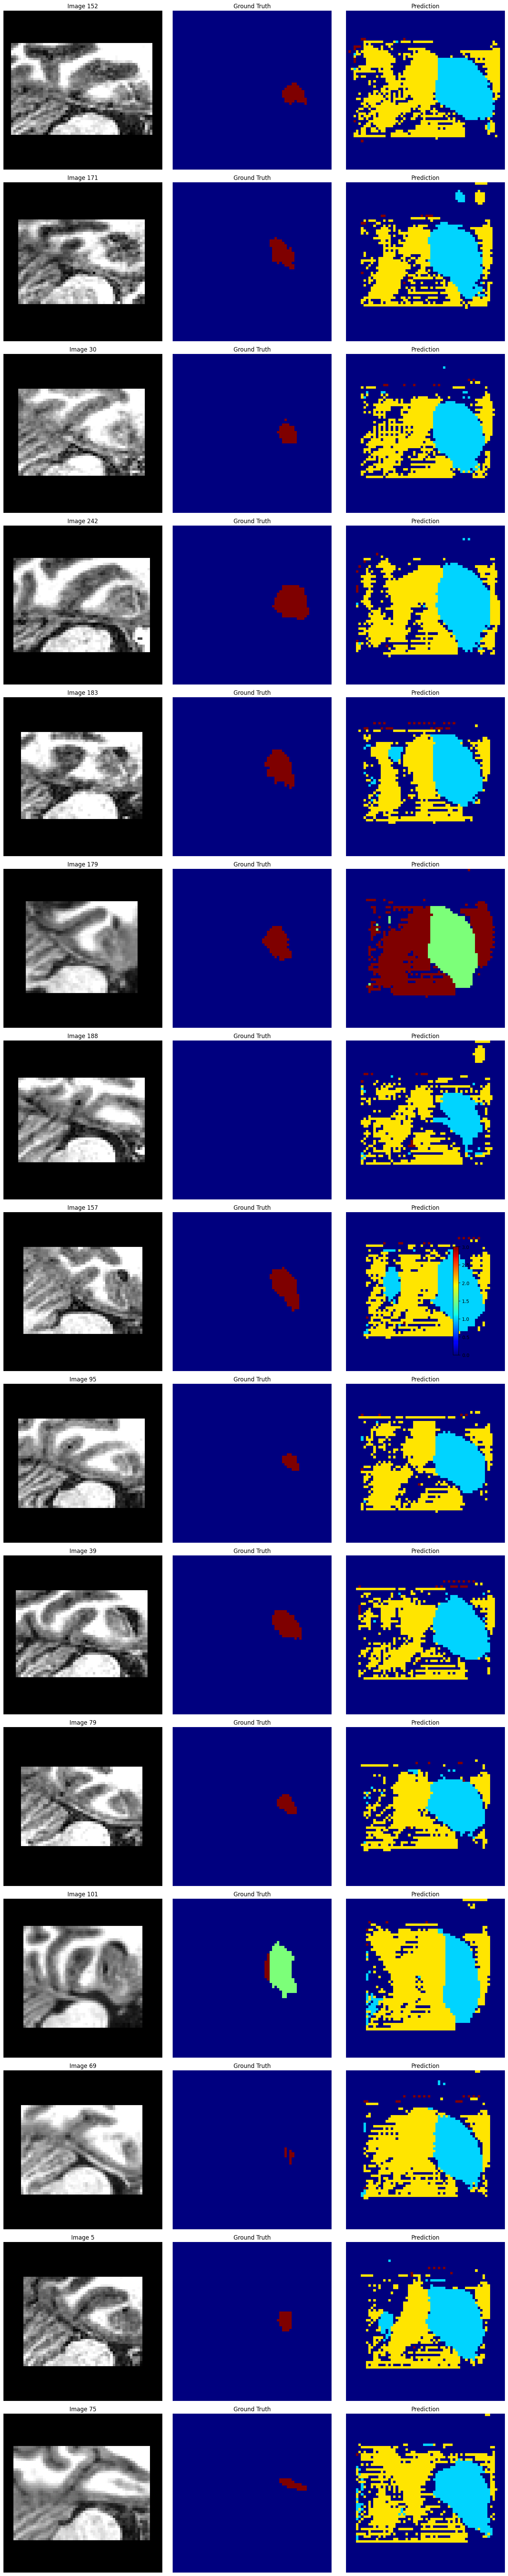

In [12]:
import torch
import os
from models.unet3d import UNet3D
from data.datasets import MedicalDecathlonDataset

# Manually specify the task and checkpoint timestamp
task_name = "Task04_Hippocampus"
checkpoint_name = "2025-03-07_17-57-48"

# Define model directory
model_dir = f"trained_models/unet3d/{task_name}"

# Load the trained model and its corresponding config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, cfg = load_model(model_dir, checkpoint_name, UNet3D)
model.to(device)

# Load dataset using the model's saved config
dataset_path = os.path.join(cfg.dataset.base_path, cfg.dataset.task_name)
images_path = os.path.join(dataset_path, cfg.dataset.images_subdir)
labels_path = os.path.join(dataset_path, cfg.dataset.labels_subdir)

dataset = MedicalDecathlonDataset(cfg, cfg.dataset.task_name, images_path, labels_path, cfg.dataset.target_shape)

# Run inference visualization
visualize_predictions(model, dataset, device, 20, num_samples=15)